# Meta OT

This tutorial covers how to learn a Meta OT initializer for Sinkhorn
{cite}`amos:22` to help predict a reasonable initialization,
and along the way we will also show how to
use a Gaussian initializer {cite}`thornton2022rethinking:22`.
These initialization schemes can greatly speed-up the convergence
of Sinkhorn algorithm, which otherwise usually starts from
a zero initialization.
Deploying optimal transport methods often involves having to solve
many similar OT problems. While Sinkhorn can be run independently
on the problems, to solve them from scratch, Meta OT methods argue that
the runtime of the solver can be significantly improved by learning
about the shared structure between the problem instances and using
it to predict an approximate starting point that can be further refined.

We will cover:

- {class}`~ott.neural.models.MetaInitializer`: The main class for the Meta OT initializer
- {class}`~ott.neural.models.MLP`: A Meta MLP to predict the dual potentials from the weights of the measures
- {class}`~ott.initializers.linear.initializers.GaussianInitializer`: The main initialization class for the Gaussian initializer

## Setup and helper functions

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main
    !pip install -q torch torchvision

In [2]:
from collections import namedtuple

import jax
import jax.numpy as jnp
import numpy as np
import torchvision

import matplotlib.pyplot as plt
from matplotlib import cm

from ott.geometry import pointcloud
from ott.initializers.linear import initializers as init_lib
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

In [3]:
# Obtain the MNIST dataset and flatten the images into discrete measures.


def get_mnist_flat(train):
    dataset = torchvision.datasets.MNIST(
        "/tmp/mnist/",
        download=True,
        train=train,
    )
    data = jnp.array(dataset.data)
    data = data / 255.0
    data = data.reshape(-1, 784)
    data = data / data.sum(axis=1, keepdims=True)
    return data


mnist_train_data = get_mnist_flat(True)
mnist_eval_data = get_mnist_flat(False)

# Set up the geometry to use the grid of pixels
sinkhorn_epsilon = 1e-2
x_grid = []
for i in jnp.linspace(1, 0, num=28):
    for j in jnp.linspace(0, 1, num=28):
        x_grid.append([j, i])
x_grid = jnp.array(x_grid)
geom = pointcloud.PointCloud(x=x_grid, epsilon=sinkhorn_epsilon)

# Sample pairs of flattened MNIST digits
OT_Pair = namedtuple("OT_Pair", "a b")


def sample_OT_pairs(key, batch_size=128, train=True):
    data = mnist_train_data if train else mnist_eval_data
    k1, k2, key = jax.random.split(key, num=3)
    I = jax.random.randint(k1, shape=[batch_size], minval=0, maxval=len(data))
    J = jax.random.randint(k2, shape=[batch_size], minval=0, maxval=len(data))
    a = data[I]
    b = data[J]
    return OT_Pair(a, b)


# Generate an interpolation between the measures by sampling from the transport map.
def interpolate(
    key,
    f,
    g,
    a,
    b,
    num_interp_frames=8,
    title=None,
    axs=None,
    num_estimation_iterations=20,
    num_samples_marginal=1000,
):
    P = geom.transport_from_potentials(f, g)
    log_P_flat = jnp.log(P).ravel()

    @jax.jit
    def sample_interp_histogram_single(key, t):
        map_samples = jax.random.categorical(
            key, logits=log_P_flat, shape=[num_samples_marginal]
        )
        a_samples = geom.x[map_samples // len(a)]
        b_samples = geom.y[map_samples % len(a)]
        interp_samples = (1.0 - t) * a_samples + t * b_samples
        interp_hist, _, _ = jnp.histogram2d(
            interp_samples[:, 1],
            interp_samples[:, 0],
            bins=jnp.linspace(0.0, 1.0, num=28 + 1),
        )
        interp_hist = jnp.flipud(interp_hist)
        return interp_hist

    def sample_interp_histogram(key, t):
        alpha_t = 0.0
        for _ in range(num_estimation_iterations):
            k1, key = jax.random.split(key)
            alpha_t += sample_interp_histogram_single(k1, t)
        alpha_t = np.array(alpha_t)
        thresh = np.quantile(alpha_t, 0.95)
        alpha_t[alpha_t > thresh] = thresh
        return alpha_t / alpha_t.max()

    if axs is None:
        nrow, ncol = 1, num_interp_frames
        fig, axs = plt.subplots(
            nrow,
            ncol,
            figsize=(1 * ncol, 1 * nrow),
            gridspec_kw={"wspace": 0, "hspace": 0},
            dpi=80,
        )

    for i, t in enumerate(jnp.linspace(0, 1, num=num_interp_frames)):
        k1, key = jax.random.split(key)
        alpha_t = sample_interp_histogram(k1, t)
        axs[i].imshow(alpha_t.reshape(28, 28), cmap=cm.Greys)

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    if title is not None:
        fig.suptitle(title, y=1.2, fontsize=20)

## Setting: optimal transport between pairs of MNIST digits

Computing the OT map between images provides a way
of connecting their pixel intensities.
For example, the OT distance between MNIST digits can
be used for classification {cite}`cuturi:13`,
which we will focus on in this tutorial.

Transporting between pairs of MNIST digits is a setting where
the OT map needs to be repeatedly computed between every pair of digits.
The standard use of optimal transport for solving these
coupling problems is to treat every problem independently
and solve each one from scratch.
This is inefficient as similar problem instances,
especially between similar digits, have similar solutions
and transport maps.

Meta OT {cite}`amos:22` is a way of learning this shared structure.
This tutorial shows how to train a meta OT model to predict
the optimal Sinkhorn potentials from the image pairs.
We will reproduce their results using 
{class}`~ott.neural.models.MetaInitializer`,
which provides an easy-to-use interface
for training and using Meta OT models.

We consider each MNIST digit (a $28 \times 28$ grayscale image) as a
discrete distribution with fixed support as pixel coordinates and the
weights are the normalized pixel intensity values corresponding
to the pixel coordinate for each digit.
Hence, $x$ and $y$ correspond to pixel coordinates, and each digit
corresponds to a discrete distribution with support of size $n_a=n_b=28\cdot28=784$. 

The next block shows how our sampling function can be used
to obtain batches of pairs of MNIST evaluation images.

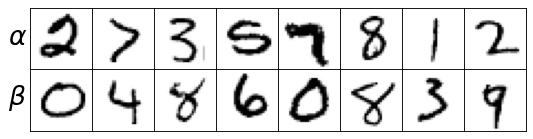

In [4]:
key = jax.random.PRNGKey(0)
num_samples = 8
demo_batch = sample_OT_pairs(key, batch_size=num_samples, train=False)

nrow, ncol = 2, num_samples
fig, axs = plt.subplots(
    nrow,
    ncol,
    figsize=(1 * ncol, 1 * nrow),
    gridspec_kw={"wspace": 0, "hspace": 0},
    dpi=80,
)

for batch_idx in range(ncol):
    axs[0, batch_idx].imshow(
        demo_batch.a[batch_idx].reshape(28, 28), cmap=cm.Greys
    )
    axs[1, batch_idx].imshow(
        demo_batch.b[batch_idx].reshape(28, 28), cmap=cm.Greys
    )

for ax in axs.ravel():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
axs[0, 0].set_ylabel(r"$\alpha$", rotation=0, size=24)
axs[0, 0].yaxis.set_label_coords(-0.2, 0.3)
axs[1, 0].set_ylabel(r"$\beta$", rotation=0, size=24)
axs[1, 0].yaxis.set_label_coords(-0.2, 0.3)

## Coupling MNIST digits with Sinkhorn

We interpret the pair of MNIST digits as discrete measures
$\alpha = \sum_{i=1}^{n_a} a_i \delta_{x_i}$ and $\beta = \sum_{j=1}^{n_b} b_j \delta_{y_j}$.
The default Sinkhorn implementation in
{class}`~ott.solvers.linear.sinkhorn.Sinkhorn`
can easily compute their optimal coupling and associated
dual potentials $f$ and $g$ from scratch.
The optimal coupling between the measures can be used
to generate an OT interpolation which shows how the
measures are connected.

This next block solves the discrete {class}`~ott.problems.linear.linear_problem.LinearProblem` associated with
the first instance of the batch above with {class}`~ott.solvers.linear.sinkhorn.Sinkhorn`
and visualizes the OT interpolation.
Given the optimal transport map $P^\star$, the interpolation shows

$$\alpha_t = (t{\rm proj}_y+(1-t){\rm proj}_x) _{\#}P^\star$$ 

where $t\in [0,1]$, ${\rm proj}_x(x,y):= x$, and ${\rm proj}_y(x,y):= y$.

In [ ]:
a, b = demo_batch.a[0], demo_batch.b[0]
prob = linear_problem.LinearProblem(geom, a=a, b=b)

solver = sinkhorn.Sinkhorn()

base_sink_out = solver(prob)
interpolate(
    key, base_sink_out.f, base_sink_out.g, a, b, title="Sinkhorn interpolation"
)

## Meta Optimal Transport

For discrete OT, Meta OT {cite}`amos:22`
predicts the optimal dual variables $f^\star$ from the input measures
$\alpha,\beta$ and geometry, which can then map to $g^\star$ and
the transport map $P^\star$:

:::{figure-md} meta-ot

<img src="https://user-images.githubusercontent.com/707462/194780650-e95fb592-65cd-4d36-9aab-eed19147701d.png" alt="Meta OT figure">

Meta OT's objective based amortization.
:::

We will consider a model $\hat f_\theta(a, b)$ that predicts the duals given the 
probabilities of the measures, i.e.  $a$ and $b$, leaving the geometry
(and cost) fixed. The MNIST measures fit into this setting because the
pixel locations remain fixed.

**Learning the model.**
The goal is for the model to match the optimal duals, i.e.,
$\hat f_\theta \approx f^\star$.
This can be done by training the predictions of $f_\theta$
to optimize the dual objective, which $f^\star$ also optimizes for.
The overall learning setup can thus be written as:

$$\min_\theta\; {\mathbb E}_{(\alpha,\beta)\sim{\mathcal{D}}}\; J(\hat f_\theta(a, b); \alpha, \beta),$$

where $a,b$ are the probabilities of the measures $\alpha,\beta$,
$\mathcal{D}$ is some distribution of optimal transport problems, and

$$-J(f; \alpha, \beta, c) := \langle f, a\rangle + \langle g, b \rangle
    - \varepsilon\left\langle \exp\{f/\varepsilon\}, K\exp\{g/\varepsilon\}\right\rangle$$

is the entropic dual objective,
and  $K_{i,j} := -C_{i,j}/\varepsilon$ is the *Gibbs kernel*.
Notably, this loss **doesn't require access to the ground-truth**
$f^\star$ and instead locally updates the predictions. In other words, the
Meta OT model simultaneously solves all of the OT problems
in the meta distribution $\mathcal{D}$ during training

The following instantiates
{class}`~ott.neural.models.MetaInitializer`,
which provides an implementation for training and deploying Meta OT models.
The default meta potential model for $f_\theta$ is a standard multi-layer MLP
defined in {class}`~ott.neural.models.MLP`
and it is optimized with {func}`~optax.adam` by default.

**Custom model and optimizers**.
The model and training procedure use
[flax](https://flax.readthedocs.io/en/latest/) and
[optax](https://optax.readthedocs.io/en/latest/).
The Meta OT initializer can take a custom-written Flax module
in  `init_model` or optimizer in `opt` that may be better-suited
to your setting than an MLP.

## Creating the initializer

We can create the initializer by providing it with the shared
geometry of the problem instances.

In [6]:
meta_initializer = init_lib.MetaInitializer(geom=geom)

## Training the Meta OT initializer

Meta OT models have a preliminary training phase where they are
given samples of OT problems from the meta distribution.
The Meta OTT initializer internally stores the training state
of the model, and {meth}`~ott.neural.models.MetaInitializer.update` will update the initialization
on a batch of problems to improve the next prediction.
While we show here a separate training phase, the update
can also be done in-tandem with deployment where the
initialization is then used with a Sinkhorn refinement
process to obtain optimal solutions.
This is appealing for deployment settings because even
if the Meta OT model is suboptimal, refining the prediction
with Sinkhorn is **guaranteed** to provide an optimal solution
to the transport problem.

In [7]:
num_train_iterations = 50_000

for train_iter in range(num_train_iterations):
    key, step_key = jax.random.split(key)
    batch = sample_OT_pairs(step_key, train=True)
    loss, init_f, meta_initializer.state = meta_initializer.update(
        meta_initializer.state, a=batch.a, b=batch.b
    )
    print(f"Train iteration: {train_iter+1} - Loss: {loss:.2e}", end="\r")

## Training complete!

Now that we have trained the model, we can next deploy it anytime we
want to make a rough prediction for new instances of the problems.
While in practice, the model can be continued to be updated in deployment
by calling {meth}`~ott.neural.models.MetaInitializer.update`,
here we will  keep the model fixed so we can evaluate it on test instances.

## Visualizing the initializations

We can visualize the interpolation provided by the Meta OT model's
prediction of the solution to the transport problems from above,
which are sampled from testing pairs of MNIST digits that
the model was not trained on.
The initializer uses the Meta OT model in {meth}`~ott.neural.models.MetaInitializer.init_dual_a`.
This shows that the initialization is extremely close to the ground-truth coupling.

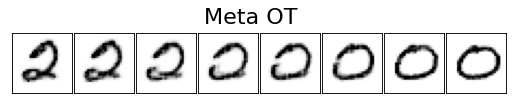

In [8]:
a, b = demo_batch.a[0], demo_batch.b[0]
ot_problem = linear_problem.LinearProblem(geom, a, b)

# Predict the optimal f duals.
f = meta_initializer.init_dual_a(ot_problem, lse_mode=True)

# Obtain the optimal g duals from the prediction.
g = geom.update_potential(f, jnp.zeros_like(b), jnp.log(b), 0, axis=0)

interpolate(key, f, g, a, b, title="Meta OT")

## Evaluating the initializers

We lastly compare how much the initializers help
{class}`~ott.solvers.linear.sinkhorn.Sinkhorn` converge on these problems, 
measured by the marginal error:

$${\rm err}(f,g; \alpha, \beta, c) := \|P1_m-a\|_1 + \|P^\top1_n-b\|_1$$

In [10]:
def get_errors(sink_out):
    return sink_out.errors[sink_out.errors > -1]


error_log = {"gaus": [], "base": [], "meta_ot": []}

num_evals = 10
eval_batch = sample_OT_pairs(
    jax.random.PRNGKey(0), batch_size=num_evals, train=False
)
for i in range(num_evals):
    a = eval_batch.a[i]
    b = eval_batch.b[i]

    sink_kwargs = {
        "threshold": -1,
        "inner_iterations": 1,
        "max_iterations": 26,
    }

    ot_problem = linear_problem.LinearProblem(geom, a=a, b=b)
    solver = sinkhorn.Sinkhorn(**sink_kwargs)

    base_sink_out = solver((None, None))

    init_dual_a = meta_initializer.init_dual_a(ot_problem, lse_mode=True)
    meta_sink_out = solver((init_dual_a, None))

    init_dual_a = init_lib.GaussianInitializer().init_dual_a(
        ot_problem, lse_mode=True
    )
    gaus_sink_out = solver((init_dual_a, None))

    error_log["base"].append(base_sink_out.errors)
    error_log["meta_ot"].append(meta_sink_out.errors)
    error_log["gaus"].append(gaus_sink_out.errors)

error_log = {key: jnp.array(errors) for (key, errors) in error_log.items()}

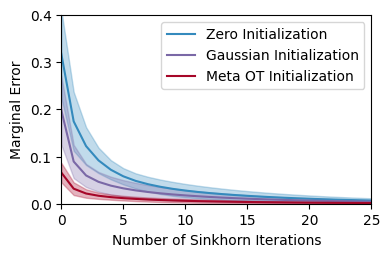

In [11]:
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=100)
tag_map = {
    "meta_ot": "Meta OT Initialization",
    "gaus": "Gaussian Initialization",
    "base": "Zero Initialization",
}

bmh_colors = plt.style.library["bmh"]["axes.prop_cycle"].by_key()["color"]
colors = [bmh_colors[0], bmh_colors[2], bmh_colors[1]]
for tag, color in zip(["base", "gaus", "meta_ot"], colors):
    mean_errors = jnp.mean(error_log[tag], axis=0)
    ax.plot(mean_errors, label=tag_map[tag], color=color)

    iters = np.arange(len(mean_errors))
    stds = jnp.std(error_log[tag], axis=0)
    ax.fill_between(
        iters, mean_errors - stds, mean_errors + stds, color=color, alpha=0.3
    )

ax.set_xlabel("Number of Sinkhorn Iterations")
ax.set_ylabel("Marginal Error")
ax.legend()
ax.set_xlim(0, 25)
ax.set_ylim(0, 0.4);